In [1]:
import numpy as np
from kdg import kdf
from kdg.utils import generate_sinewave, hellinger, plot_2dsim, generate_ood_samples, sample_unifrom_circle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from joblib import Parallel, delayed
from scipy.io import savemat, loadmat
from sklearn.metrics import roc_auc_score
import pickle

### Visualize the data

<AxesSubplot: >

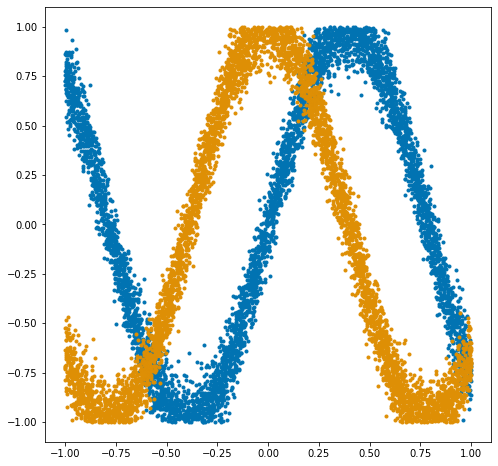

In [2]:
X, y = generate_sinewave(10000)
plot_2dsim(X, y)

### Calculate posteriors and likelihoods using KDF

In [3]:
df = {}
model_kdf = kdf(kwargs={'n_estimators':500})
model_kdf.fit(X, y, k=1e9)

#define grids
p = np.arange(-2, 2, step=0.01)
q = np.arange(-2, 2, step=0.01)
xx, yy = np.meshgrid(p, q)

grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
posterior_rf = model_kdf.rf_model.predict_proba(grid_samples)
posterior_kdf, likelihoods_kdf = model_kdf.predict_proba(grid_samples, return_likelihood=True)

posterior_rf = posterior_rf[:,0].reshape(400,400)
posterior_kdf = posterior_kdf[:,0].reshape(400,400)
class1_likelihoods = likelihoods_kdf[:,0].reshape(400,400)
class2_likelihoods = likelihoods_kdf[:,1].reshape(400,400)

df['posterior_rf'] = posterior_rf
df['posterior_kdf'] = posterior_kdf
df['likelihood_class1'] = class1_likelihoods
df['likelihood_class2'] = class2_likelihoods

In [5]:
# get true posterior
tp_df = pd.read_csv("../true_posterior/sinewave_pdf.csv")
proba_true = 0.5*np.ones((400, 400))
tmp = np.array([tp_df["posterior"][x] for x in range(40000)])
tmp = tmp.reshape(200, 200)
proba_true[100:300, 100:300] = 1 - tmp

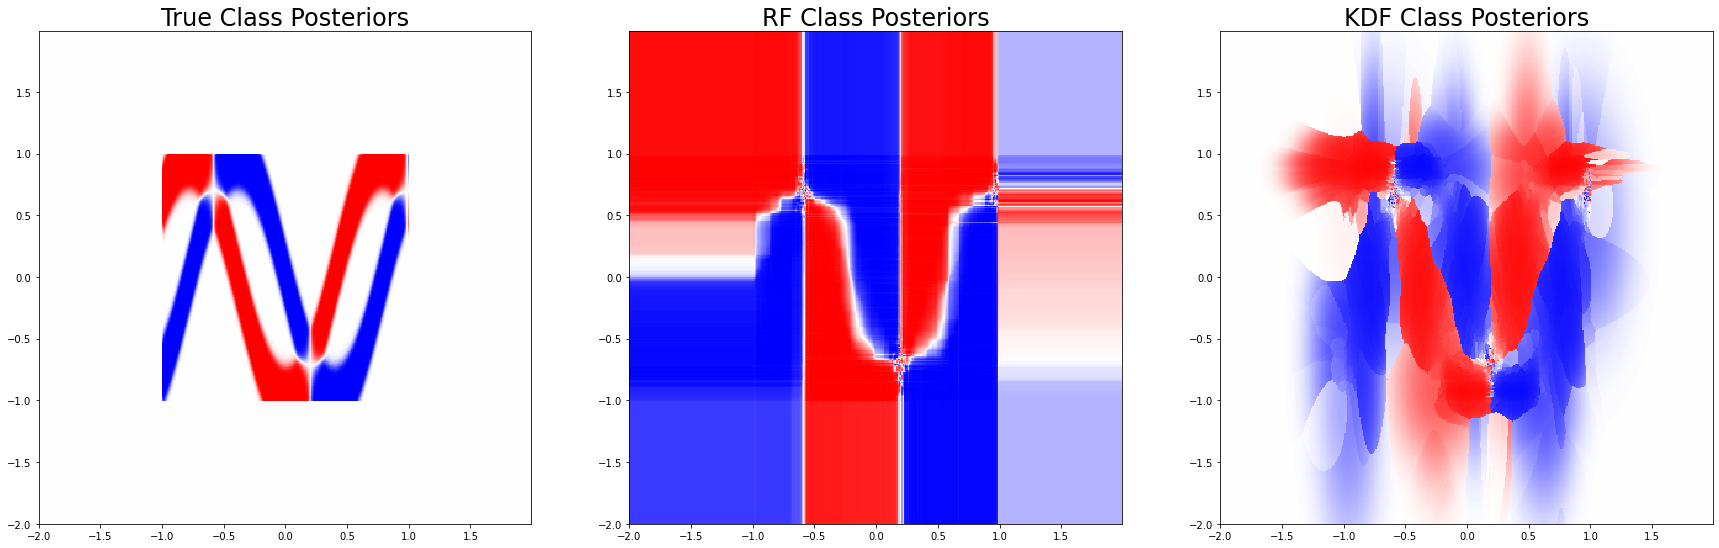

In [6]:
fig1, ax = plt.subplots(1, 3, figsize=(30, 90))

ax0 = ax[0].imshow(
    proba_true,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("True Class Posteriors", fontsize=24)
ax[0].set_aspect("equal")

ax1 = ax[1].imshow(
    1-posterior_rf,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("RF Class Posteriors", fontsize=24)
ax[1].set_aspect("equal")

ax2 = ax[2].imshow(
    1-posterior_kdf,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("KDF Class Posteriors", fontsize=24)
ax[2].set_aspect("equal")
plt.show()

### Visualize class likelihoods

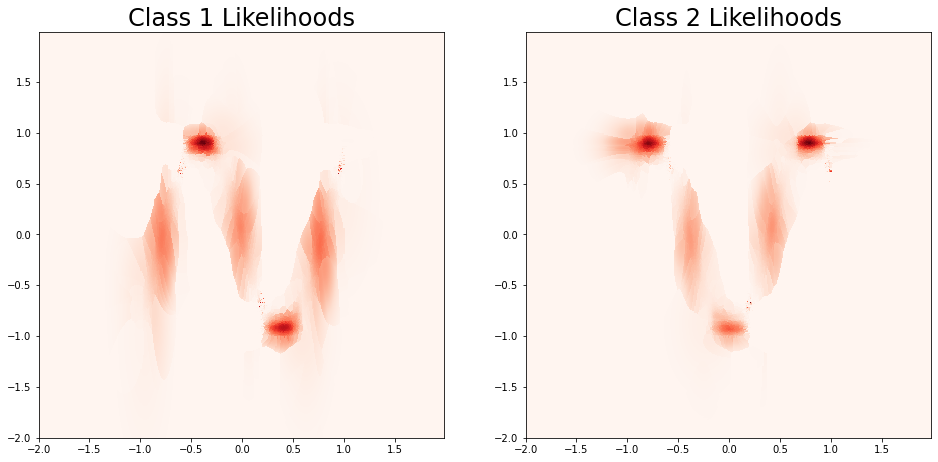

In [7]:
fig1, ax = plt.subplots(1, 2, figsize=(16, 8))

ax0 = ax[0].imshow(
    class1_likelihoods,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("Class 1 Likelihoods", fontsize=24)
ax[0].set_aspect("equal")


ax1 = ax[1].imshow(
    class2_likelihoods,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("Class 2 Likelihoods", fontsize=24)
ax[1].set_aspect("equal")

### Experiment with misclassification error and hellinger distance

In [19]:
mc_reps = 45
sample_size = [50, 100, 500, 1000, 5000, 10000]
n_test = 1000

tp_df = pd.read_csv("../true_posterior/sinewave_pdf.csv")
true_posterior = tp_df['posterior']
true_posterior = np.vstack((true_posterior.ravel(), 1-true_posterior.ravel())).T
        
    
def experiment_in(sample, n_test, true_posterior):
    X, y = generate_sinewave(sample)
    X_test, y_test = generate_sinewave(n_test)

    p = np.arange(-1, 1, step=0.01)
    q = np.arange(-1, 1, step=0.01)
    xx, yy = np.meshgrid(p, q)

    grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

    model_kdf = kdf(kwargs={'n_estimators':500})
    model_kdf.fit(X, y, k=1e9)

    error_kdf = 1 - np.mean(model_kdf.predict(X_test)==y_test)
    error_rf = 1 - np.mean(model_kdf.rf_model.predict(X_test)==y_test)
    error_tree = 1 - np.mean(model_kdf.rf_model.estimators_[0].predict(X_test)==y_test)
    
    proba_kdf = model_kdf.predict_proba(grid_samples)
    proba_rf = model_kdf.rf_model.predict_proba(grid_samples)
    proba_tree = model_kdf.rf_model.estimators_[0].predict_proba(grid_samples)
    
    hellinger_dis_kdf = hellinger(true_posterior, proba_kdf)
    hellinger_dis_rf = hellinger(true_posterior, proba_rf)
    hellinger_dis_tree = hellinger(true_posterior, proba_tree)
    
    mmcIn_rf = np.mean(np.max(proba_rf, axis=1)) 
    mmcIn_kdf = np.mean(np.max(proba_kdf, axis=1))
    mmcIn_tree = np.mean(np.max(proba_tree, axis=1))
    
    return error_kdf, error_rf, error_tree, hellinger_dis_kdf, hellinger_dis_rf, hellinger_dis_tree, mmcIn_kdf, mmcIn_rf, mmcIn_tree

def experiment_out(in_sample, r, n_test):
    X, y = generate_sinewave(in_sample)
    model_kdf = kdf(kwargs={'n_estimators':500})
    model_kdf.fit(X, y, k=1e3)

    X_ood = sample_unifrom_circle(n=n_test, r=r)
    mmcOut_rf = np.mean(np.max(model_kdf.rf_model.predict_proba(X_ood), axis=1))
    mmcOut_kdf = np.mean(np.max(model_kdf.predict_proba(X_ood), axis=1))
    mmcOut_tree = np.mean(np.max(model_kdf.rf_model.estimators_[0].predict_proba(X_ood), axis=1))
    
    return mmcOut_kdf, mmcOut_rf, mmcOut_tree
        
    
error_kdf_med = []
error_kdf_25 = []
error_kdf_75 = []
error_rf_med = []
error_rf_25 = []
error_rf_75 = []
error_tree_med = []
error_tree_25 = []
error_tree_75 = []

hellinger_kdf_med = []
hellinger_kdf_25 = []
hellinger_kdf_75 = []
hellinger_rf_med = []
hellinger_rf_25 = []
hellinger_rf_75 = []
hellinger_tree_med = []
hellinger_tree_25 = []
hellinger_tree_75 = []

mmcIn_kdf_med = []
mmcIn_kdf_25 = []
mmcIn_kdf_75 = []
mmcIn_rf_med = []
mmcIn_rf_25 = []
mmcIn_rf_75 = []
mmcIn_tree_med = []
mmcIn_tree_25 = []
mmcIn_tree_75 = []

mmcOut_kdf_med = []
mmcOut_kdf_25 = []
mmcOut_kdf_75 = []
mmcOut_rf_med = []
mmcOut_rf_25 = []
mmcOut_rf_75 = []

mmcOut_tree_med = []
mmcOut_tree_25 = []
mmcOut_tree_75 = []

#### do out-of-distribution results ####
for r in np.arange(0,10.5,.5):
    mmcOut_kdf = []
    mmcOut_rf = []
    mmcOut_tree = []
    
    res = Parallel(n_jobs=-1)(
            delayed(experiment_out)(
                    1000,
                    r,
                    n_test
                    ) for _ in range(mc_reps)
                )
    
    for ii in range(mc_reps):
        mmcOut_kdf.append(res[ii][0])
        mmcOut_rf.append(res[ii][1])
        mmcOut_tree.append(res[ii][2])
    
    
    mmcOut_kdf_med.append(
        np.median(mmcOut_kdf)
    )
    mmcOut_kdf_25.append(
        np.quantile(mmcOut_kdf, [0.25])[0]
    )
    mmcOut_kdf_75.append(
        np.quantile(mmcOut_kdf, [0.75])[0]
    )
    
    mmcOut_rf_med.append(
        np.median(mmcOut_rf)
    )
    mmcOut_rf_25.append(
        np.quantile(mmcOut_rf, [0.25])[0]
    )
    mmcOut_rf_75.append(
        np.quantile(mmcOut_rf, [0.75])[0]
    )
    
    mmcOut_tree_med.append(
        np.median(mmcOut_tree)
    )
    mmcOut_tree_25.append(
        np.quantile(mmcOut_tree, [0.25])[0]
    )
    mmcOut_tree_75.append(
        np.quantile(mmcOut_tree, [0.75])[0]
    )
    
    
#### do in-distribution results ####
for sample in sample_size:
    res = Parallel(n_jobs=-1)(
            delayed(experiment_in)(
                    sample,
                    n_test,
                    true_posterior
                    ) for _ in range(mc_reps)
                )

    
    err_kdf = []
    err_rf = []
    err_tree = []
    hellinger_kdf = []
    hellinger_rf = []
    hellinger_tree = []
    mmcIn_kdf = []
    mmcIn_rf = []
    mmcIn_tree = []
    for ii in range(mc_reps):
        err_kdf.append(res[ii][0])
        err_rf.append(res[ii][1])
        err_tree.append(res[ii][2])
        hellinger_kdf.append(res[ii][3])
        hellinger_rf.append(res[ii][4])
        hellinger_tree.append(res[ii][5])
        mmcIn_kdf.append(res[ii][6])
        mmcIn_rf.append(res[ii][7])
        mmcIn_tree.append(res[ii][8])

    error_kdf_med.append(
        np.median(err_kdf)
    )
    error_kdf_25.append(
        np.quantile(err_kdf, [0.25])[0]
    )
    error_kdf_75.append(
        np.quantile(err_kdf, [0.75])[0]
    )

    error_rf_med.append(
        np.median(err_rf)
    )
    error_rf_25.append(
        np.quantile(err_rf, [0.25])[0]
    )
    error_rf_75.append(
        np.quantile(err_rf, [0.75])[0]
    )
    
    error_tree_med.append(
        np.median(err_tree)
    )
    error_tree_25.append(
        np.quantile(err_tree, [0.25])[0]
    )
    error_tree_75.append(
        np.quantile(err_tree, [0.75])[0]
    )
    
    hellinger_kdf_med.append(
        np.median(hellinger_kdf)
    )
    hellinger_kdf_25.append(
        np.quantile(hellinger_kdf, [0.25])[0]
    )
    hellinger_kdf_75.append(
        np.quantile(hellinger_kdf, [0.75])[0]
    )

    hellinger_rf_med.append(
        np.median(hellinger_rf)
    )
    hellinger_rf_25.append(
        np.quantile(hellinger_rf, [0.25])[0]
    )
    hellinger_rf_75.append(
        np.quantile(hellinger_rf, [0.75])[0]
    )
    
    hellinger_tree_med.append(
        np.median(hellinger_tree)
    )
    hellinger_tree_25.append(
        np.quantile(hellinger_tree, [0.25])[0]
    )
    hellinger_tree_75.append(
        np.quantile(hellinger_tree, [0.75])[0]
    )
    
    mmcIn_kdf_med.append(
        np.median(mmcIn_kdf)
    )
    mmcIn_kdf_25.append(
        np.quantile(mmcIn_kdf, [0.25])[0]
    )
    mmcIn_kdf_75.append(
        np.quantile(mmcIn_kdf, [0.75])[0]
    )

    mmcIn_rf_med.append(
        np.median(mmcIn_rf)
    )
    mmcIn_rf_25.append(
        np.quantile(mmcIn_rf, [0.25])[0]
    )
    mmcIn_rf_75.append(
        np.quantile(mmcIn_rf, [0.75])[0]
    )
    
    mmcIn_tree_med.append(
        np.median(mmcIn_tree)
    )
    mmcIn_tree_25.append(
        np.quantile(mmcIn_tree, [0.25])[0]
    )
    mmcIn_tree_75.append(
        np.quantile(mmcIn_tree, [0.75])[0]
    )

df['error_kdf_med'] = error_kdf_med
df['error_kdf_25'] = error_kdf_25
df['error_kdf_75'] = error_kdf_75

df['error_rf_med'] = error_rf_med
df['error_rf_25'] = error_rf_25
df['error_rf_75'] = error_rf_75

df['error_tree_med'] = error_tree_med
df['error_tree_25'] = error_tree_25
df['error_tree_75'] = error_tree_75

df['hellinger_kdf_med'] = hellinger_kdf_med
df['hellinger_kdf_25'] = hellinger_kdf_25
df['hellinger_kdf_75'] = hellinger_kdf_75

df['hellinger_rf_med'] = hellinger_rf_med
df['hellinger_rf_25'] = hellinger_rf_25
df['hellinger_rf_75'] = hellinger_rf_75

df['hellinger_tree_med'] = hellinger_tree_med
df['hellinger_tree_25'] = hellinger_tree_25
df['hellinger_tree_75'] = hellinger_tree_75

df['mmcIn_kdf_med'] = mmcIn_kdf_med
df['mmcIn_kdf_25'] = mmcIn_kdf_25
df['mmcIn_kdf_75'] = mmcIn_kdf_75

df['mmcIn_rf_med'] = mmcIn_rf_med
df['mmcIn_rf_25'] = mmcIn_rf_25
df['mmcIn_rf_75'] = mmcIn_rf_75

df['mmcIn_tree_med'] = mmcIn_tree_med
df['mmcIn_tree_25'] = mmcIn_tree_25
df['mmcIn_tree_75'] = mmcIn_tree_75

df['mmcOut_kdf_med'] = mmcOut_kdf_med
df['mmcOut_kdf_25'] = mmcOut_kdf_25
df['mmcOut_kdf_75'] = mmcOut_kdf_75

df['mmcOut_rf_med'] = mmcOut_rf_med
df['mmcOut_rf_25'] = mmcOut_rf_25
df['mmcOut_rf_75'] = mmcOut_rf_75

df['mmcOut_tree_med'] = mmcOut_tree_med
df['mmcOut_tree_25'] = mmcOut_tree_25
df['mmcOut_tree_75'] = mmcOut_tree_75

### Save the result

In [20]:
name = 'results/sinewave'
filename = name + ".pickle"

with open(filename, 'wb') as f:
    pickle.dump(df, f)

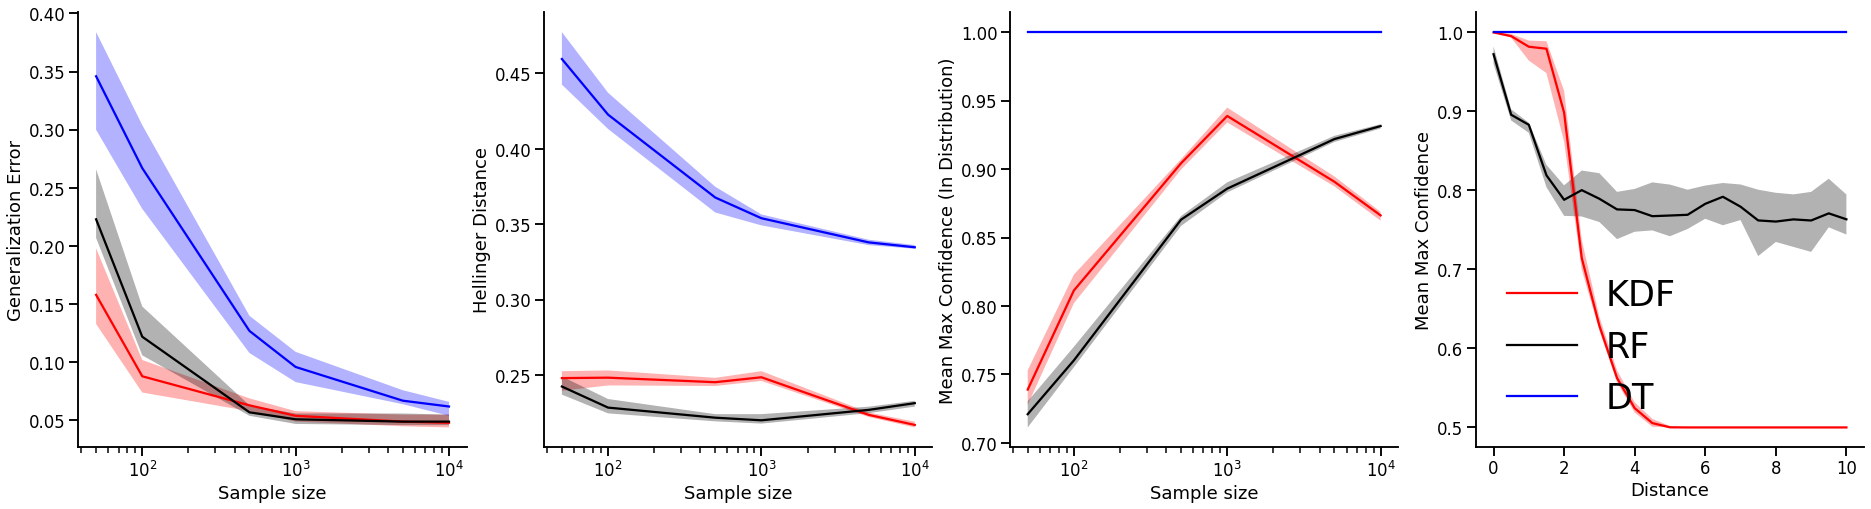

In [21]:
sample_size = [50, 100, 500, 1000, 5000, 10000]

sns.set_context('talk')
fig, ax = plt.subplots(1,4, figsize=(32,8))

ax[0].plot(sample_size, df['error_kdf_med'], c="r", label='KDF')
ax[0].plot(sample_size, df['error_rf_med'], c="k", label='RF')
ax[0].plot(sample_size, df['error_tree_med'], c="b", label='DT')

ax[0].fill_between(sample_size, df['error_kdf_25'], df['error_kdf_75'], facecolor='r', alpha=.3)
ax[0].fill_between(sample_size, df['error_rf_25'], df['error_rf_75'], facecolor='k', alpha=.3)
ax[0].fill_between(sample_size, df['error_tree_25'], df['error_tree_75'], facecolor='b', alpha=.3)

ax[0].set_xscale('log')
ax[0].set_xlabel('Sample size')
ax[0].set_ylabel('Generalization Error')

right_side = ax[0].spines["right"]
right_side.set_visible(False)
top_side = ax[0].spines["top"]
top_side.set_visible(False)




ax[1].plot(sample_size, df['hellinger_kdf_med'], c="r", label='KDF')
ax[1].plot(sample_size, df['hellinger_rf_med'], c="k", label='RF')
ax[1].plot(sample_size, df['hellinger_tree_med'], c="b", label='DT')

ax[1].fill_between(sample_size, df['hellinger_kdf_25'], df['hellinger_kdf_75'], facecolor='r', alpha=.3)
ax[1].fill_between(sample_size, df['hellinger_rf_25'], df['hellinger_rf_75'], facecolor='k', alpha=.3)
ax[1].fill_between(sample_size, df['hellinger_tree_25'], df['hellinger_tree_75'], facecolor='b', alpha=.3)


ax[1].set_xscale('log')
ax[1].set_xlabel('Sample size')
ax[1].set_ylabel('Hellinger Distance')

right_side = ax[1].spines["right"]
right_side.set_visible(False)
top_side = ax[1].spines["top"]
top_side.set_visible(False)




ax[2].plot(sample_size, df['mmcIn_kdf_med'], c="r", label='KDF')
ax[2].plot(sample_size, df['mmcIn_rf_med'], c="k", label='RF')
ax[2].plot(sample_size, df['mmcIn_tree_med'], c="b", label='DT')

ax[2].fill_between(sample_size, df['mmcIn_kdf_25'], df['mmcIn_kdf_75'], facecolor='r', alpha=.3)
ax[2].fill_between(sample_size, df['mmcIn_rf_25'], df['mmcIn_rf_75'], facecolor='k', alpha=.3)
ax[2].fill_between(sample_size, df['mmcIn_tree_25'], df['mmcIn_tree_75'], facecolor='b', alpha=.3)

ax[2].set_xscale('log')
ax[2].set_xlabel('Sample size')
ax[2].set_ylabel('Mean Max Confidence (In Distribution)')

right_side = ax[2].spines["right"]
right_side.set_visible(False)
top_side = ax[2].spines["top"]
top_side.set_visible(False)


r = np.arange(0,10.5,.5)
ax[3].plot(r, df['mmcOut_kdf_med'], c="r", label='KDF')
ax[3].plot(r, df['mmcOut_rf_med'], c="k", label='RF')
ax[3].plot(r, df['mmcOut_tree_med'], c="b", label='DT')

ax[3].fill_between(r, df['mmcOut_kdf_25'], df['mmcOut_kdf_75'], facecolor='r', alpha=.3)
ax[3].fill_between(r, df['mmcOut_rf_25'], df['mmcOut_rf_75'], facecolor='k', alpha=.3)
ax[3].fill_between(r, df['mmcOut_tree_25'], df['mmcOut_tree_75'], facecolor='b', alpha=.3)

#ax[3].set_xscale('log')
ax[3].set_xlabel('Distance')
ax[3].set_ylabel('Mean Max Confidence')

ax[3].legend(fontsize=35, frameon=False)

right_side = ax[3].spines["right"]
right_side.set_visible(False)
top_side = ax[3].spines["top"]
top_side.set_visible(False)

### OOD detection metrics

In [10]:
def fpr_at_95_tpr(conf_t, conf_f):
    TPR = 95
    PERC = np.percentile(conf_t, 100-TPR)
    FP = np.sum(conf_f >=  PERC)
    FPR = np.sum(conf_f >=  PERC)/len(conf_f)
    return FPR, PERC

In [11]:
sample = 10000
reps = 45
n_test = 1000
true_labels = np.hstack((np.ones(n_test, ), np.zeros(n_test, )))

roc_rf = []
roc_kdf = []

fpr_rf = []
fpr_kdf = []
reps_list = []

for ii in range(reps):
    X, y = generate_sinewave(sample)
    X_test, y_test = generate_sinewave(n_test)
    X_ood = generate_ood_samples(n_test)

    
    model_kdf = kdf(kwargs={'n_estimators':500})
    model_kdf.fit(X, y)

    rf_in_conf = np.max(model_kdf.rf_model.predict_proba(X_test), axis=1)
    rf_out_conf = np.max(model_kdf.rf_model.predict_proba(X_ood), axis=1)
    rf_conf = np.hstack((rf_in_conf, rf_out_conf))
    roc_rf.append(
        roc_auc_score(true_labels, rf_conf)
    )
    fpr_rf.append(
        fpr_at_95_tpr(rf_in_conf, rf_out_conf)
    )
    
    

    kdf_in_conf = np.max(model_kdf.predict_proba(X_test), axis=1)
    kdf_out_conf = np.max(model_kdf.predict_proba(X_ood), axis=1)
    kdf_conf = np.hstack((kdf_in_conf, kdf_out_conf))
    roc_kdf.append(
        roc_auc_score(true_labels, kdf_conf)
    )
    fpr_kdf.append(
        fpr_at_95_tpr(kdf_in_conf, kdf_out_conf)
    )

    reps_list.append(ii)

In [12]:
# obtain the AUROC and FPR@95 scores

# AUROC
print("KDF AUROC = {:.3f} +/- {:.3f}".format(np.mean(roc_kdf), np.std(roc_kdf)))
print("RF AUROC = {:.3f} +/- {:.3f}".format(np.mean(roc_rf), np.std(roc_rf)))

KDF AUROC = 0.926 +/- 0.008
RF AUROC = 0.858 +/- 0.040


In [13]:
# FPR@95
print("KDF FPR@95 = {:.3f} +/- {:.3f}".format(np.mean(fpr_kdf), np.std(fpr_kdf)))
print("RF FPR@95 = {:.3f} +/- {:.3f}".format(np.mean(fpr_rf), np.std(fpr_rf)))

KDF FPR@95 = 0.493 +/- 0.297
RF FPR@95 = 0.688 +/- 0.077
